Code to reload the sample generated by diffusion and get III results.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from time import perf_counter
from functools import partial
import random
from numba import jit
import scipy as sp

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
b = np.load("ising_h.npy")
w = np.load("ising_J.npy")
s = np.load("ising_samples.npy")

In [3]:
import math
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# -------------------------------
# 2️Diffusion MLP (논문 구조)
# -------------------------------
class DiffusionMLP(nn.Module):
    def __init__(self, input_dim=40):
        super().__init__()
        time_embed_dim = 128
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)

        self.enc1 = nn.Linear(input_dim + time_embed_dim, 128)
        self.enc2 = nn.Linear(128, 256)
        self.enc3 = nn.Linear(256, 512)

        self.dec1 = nn.Linear(512, 512)
        self.dec2 = nn.Linear(512, 512)
        self.dec3 = nn.Linear(512, 256)
        self.dec4 = nn.Linear(256, 128)

        self.out = nn.Linear(128, input_dim)
        self.act = nn.GELU()

    def forward(self, x, t):
        t_embed = self.time_embed(t).to(x.dtype)
        h = torch.cat([x, t_embed], dim=1)

        h1 = self.act(self.enc1(h))
        h2 = self.act(self.enc2(h1))
        h3 = self.act(self.enc3(h2))

        d1 = self.act(self.dec1(h3))
        d2 = self.act(self.dec2(d1) + d1)
        d3 = self.act(self.dec3(d2) + h2)
        d4 = self.act(self.dec4(d3) + h1)

        return self.out(d4)

# -------------------------------
# 3 DDPM Schedules
# -------------------------------
def ddpm_schedules(beta_start, beta_end, n_T):
    betas = torch.linspace(beta_start, beta_end, n_T)
    alphas = 1. - betas
    alphabar = torch.cumprod(alphas, dim=0)

    return {
        'beta_t': betas,
        'alpha_t': alphas,
        'alphabar_t': alphabar,
        'sqrtab': torch.sqrt(alphabar),
        'sqrtmab': torch.sqrt(1 - alphabar),
        'oneover_sqrta': 1. / torch.sqrt(alphas),
        'bt_over_sqrtmab': betas / torch.sqrt(1 - alphabar),
        'sqrt_beta_t': torch.sqrt(betas),
    }

# -------------------------------
# 4️ DDPM Class (Device 문제 해결)
# -------------------------------
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super().__init__()
        self.nn_model = nn_model
        self.n_T = n_T
        self.device = device

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.to(device)  

    def forward(self, x):
        batch_size = x.size(0)
        t = torch.randint(1, self.n_T+1, (batch_size,), device=x.device).float()

        sqrtab_t = self.sqrtab[t.long()-1].view(batch_size, 1)
        sqrtmab_t = self.sqrtmab[t.long()-1].view(batch_size, 1)

        epsilon = torch.randn_like(x)
        x_t = sqrtab_t * x + sqrtmab_t * epsilon

        pred_epsilon = self.nn_model(x_t, t)
        loss = F.mse_loss(pred_epsilon, epsilon)
        return loss

    def sample(self, n_sample, size):
        x = torch.randn(n_sample, size).to(self.device)
        x_seq = []

        for t in reversed(range(1, self.n_T+1)):
            t_batch = torch.full((n_sample,), t, device=self.device).float()
            epsilon_pred = self.nn_model(x, t_batch)

            mu = self.oneover_sqrta[t-1] * (x - self.bt_over_sqrtmab[t-1] * epsilon_pred)
            sigma = self.sqrt_beta_t[t-1]

            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            x = mu + sigma * z

            if t % (self.n_T // 10) == 0 or t == 1:
                x_seq.append(x.detach().cpu().numpy())

        return x, np.array(x_seq)


# ------------------------------
# 5. Training Loop & 샘플링
# ------------------------------
# 모델 인스턴스 생성 (구조 동일해야 함!)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


n_sample_per_batch = 5000
n_batches = 10  # 1000 * 100 = 100,000
N = 40
# for epoch in range(1, 50):
#     real_epoch = epoch *1000
#     model = DiffusionMLP(input_dim=40)
#     ddpm = DDPM(model, betas=(0.0001, 0.02), n_T=1000, device=device)
#     model.load_state_dict(torch.load(f"final/finalmodel_epoch_{real_epoch-1}.pth"))
#     model.eval() 
#     for batch_idx in range(n_batches):
#         with torch.no_grad():  # 추가!

#             x_diff, _ = ddpm.sample(n_sample_per_batch, size=40)
#             x_diff = np.sign(x_diff.cpu().numpy())

#             # os.makedirs(f"final/final_sample_{real_epoch}/", exist_ok=True)
#             # np.save(f"final/final_sample_{real_epoch}/{batch_idx+10:03d}.npy", x_diff)

#         torch.cuda.empty_cache()  # 추가: 메모리 해제!

In [4]:
import numpy as np
import os
epoch = 32000
def load_samples( total_samples: int,epoch :int, batch_size: int = 5000, base_dir: str = '.'):
    """
    label: 'freq', 'rare', 'null'
    total_samples: 불러올 총 샘플 수
    batch_size: 한 파일에 저장된 샘플 수
    base_dir: npy 파일이 저장된 디렉토리
    """
    n_batches = total_samples // batch_size
    all_samples = []

    file_path = os.path.join(base_dir, f"final/ddpm_samples_epoch_{epoch}.npy")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"파일 없음: {file_path}")
    batch = np.load(file_path)
    all_samples.append(batch)

    samples = np.vstack(all_samples)
    return samples


def load_multi_samples(name : int, total_samples: int, batch_size: int = 5000, base_dir: str = '.'):
    """
    label: 'freq', 'rare', 'null'
    total_samples: 불러올 총 샘플 수
    batch_size: 한 파일에 저장된 샘플 수
    base_dir: npy 파일이 저장된 디렉토리
    """
    n_batches = total_samples // batch_size
    all_samples = []

    for i in range(n_batches):
        file_path = os.path.join(base_dir, f"final/final_sample_{name}/{i:03d}.npy")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"파일 없음: {file_path}")
        batch = np.load(file_path)
        all_samples.append(batch)

    samples = np.vstack(all_samples)
    return samples

In [5]:
x =load_multi_samples(name = 32000, batch_size=5000, total_samples=50000)
x.shape

(50000, 40)

In [6]:
def energy_general_ising(seq, b, w):
    field_term = -np.dot(b, seq)
    interaction_term = -np.sum(np.triu(w, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def metropolis_sample(L, b, w, beta=1.0, n_steps=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    seq = np.random.choice([-1, 1], size=L)
    local_field = b + np.dot(w, seq)

    for step in range(n_steps):
        i = np.random.randint(L)
        dE = 2 * seq[i] * local_field[i]

        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            seq[i] *= -1
            local_field += 2 * w[:, i] * seq[i]

    return seq

def sample_general_ising(L, N, b, w, beta=1.0, n_steps=1000, n_jobs=10):
    from joblib import parallel_backend

    seeds = np.random.randint(0, 1e6, size=N)

    with parallel_backend('loky'):
        samples = Parallel(n_jobs=n_jobs)(
            delayed(metropolis_sample)(L, b, w, beta, n_steps, int(seeds[i]))
            for i in tqdm(range(N), desc="Sampling Ising states", unit="sample")
        )

    return np.array(samples)

def plot_energy_histogram_general(samples, b, w, color='cornflowerblue', bins = 30):
    energies = np.array([energy_general_ising(s, b, w) for s in samples])
    plt.hist(energies, bins=bins, density=True, color=color, edgecolor='black', alpha=0.6)
    plt.title(f"Ising Model Energy Histogram L = {L}")
    plt.xlabel("Energy")
    plt.ylabel("A.U.")
    plt.grid(True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_energy(seq, b, w):
    field_term = -np.dot(b, seq)
    interaction_term = -np.sum(np.triu(w, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def estimate_f_epsilon(samples, b, w, epsilon):
    energies = np.array([compute_energy(s, b, w) for s in samples])
    ps = np.exp(-energies)
    ps_epsilon = ps ** (-1 + epsilon)
    weights = ps_epsilon / np.sum(ps_epsilon)
    return weights


def update_parameters(samples, b, w, epsilon, lr):
    n = samples.shape[1]
    weights = estimate_f_epsilon(samples, b, w, epsilon)

    mean_sigma = np.zeros(n)
    for s, wgt in zip(samples, weights):
        mean_sigma += wgt * s
    #mean_sigma = np.average(samples, axis=0, weights=weights)  # ⟨σ_i⟩_{f_ε}
    mean_sigma_sigma = np.zeros((n, n))
    for s, wgt in zip(samples, weights):
        #mean_sigma_sigma += wgt * np.einsum("i,j->ij", s, s)
        mean_sigma_sigma += wgt * np.outer(s, s)
    np.fill_diagonal(mean_sigma_sigma, 0)
    b_model = epsilon * b
    w_model = epsilon * w

    #print(np.linalg.norm(mean_sigma - b_model))
    
    # Gradient update
    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)
    
    return b_new, w_new

# === Example Usage ===
def train_erasure_machine(samples, n, epsilon=0.05, lr=0.1, epochs=100):
    b_temp = np.random.randn(n) * 0.01
    w_temp = np.random.randn(n, n) * 0.01
    w_temp = (w_temp + w_temp.T) / 2  # Make symmetric
    np.fill_diagonal(w_temp, 0)

    for epoch in range(epochs):
        b_temp, w_temp = update_parameters(samples, b_temp, w_temp, epsilon, lr)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: b norm = {np.linalg.norm(b_temp):.4f}, w norm = {np.linalg.norm(w_temp):.4f}")
    return b_temp, w_temp

L = 40
def mse(w, w_e, b, b_e) :
    LL = L + L*(L-1)/2
    b_error = np.sum((b_e - b)**2)/LL
    mask = np.triu(np.ones_like(w), k=1)
    w_diff = (w_e - w) * mask
    w_error = np.sum(w_diff**2)/LL
    return (b_error + w_error)

In [7]:
import torch
import numpy as np

def compute_energy_torch(samples, b, w):
    # energy = -b·σ - sum_{i<j} w_ij σ_i σ_j
    field_term = -torch.matmul(samples, b)
    interaction_term = -0.5 * torch.sum(samples @ w * samples, dim=1)
    return field_term + interaction_term

def estimate_f_epsilon_torch(samples, b, w, epsilon):
    with torch.no_grad():
        energies = compute_energy_torch(samples, b, w)
        ps = torch.exp(-energies)
        ps_epsilon = ps ** (-1 + epsilon)
        weights = ps_epsilon / ps_epsilon.sum()
    return weights

def update_parameters_torch(samples, b, w, epsilon, lr):
    weights = estimate_f_epsilon_torch(samples, b, w, epsilon)

    mean_sigma = torch.sum(weights[:, None] * samples, dim=0)

    outer = samples.unsqueeze(2) * samples.unsqueeze(1)  # shape: (N, L, L)
    weighted_outer = weights[:, None, None] * outer
    mean_sigma_sigma = torch.sum(weighted_outer, dim=0)
    mean_sigma_sigma.fill_diagonal_(0.0)

    b_model = epsilon * b
    w_model = epsilon * w

    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)

    return b_new, w_new

def train_erasure_machine_torch(samples_np, n, epsilon=0.05, lr=0.1, epochs=100, use_cuda=True):
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    samples = torch.tensor(samples_np, dtype=torch.float32, device=device)

    b = torch.randn(n, device=device) * 0.01
    w = torch.randn(n, n, device=device) * 0.01
    w = (w + w.T) / 2
    w.fill_diagonal_(0.0)

    for epoch in range(epochs):
        b, w = update_parameters_torch(samples, b, w, epsilon, lr)
        if epoch % 10 == 0:
            print(f"[GPU] Epoch {epoch}: b norm = {b.norm():.4f}, w norm = {w.norm():.4f}")
    return b.cpu().numpy(), w.cpu().numpy()


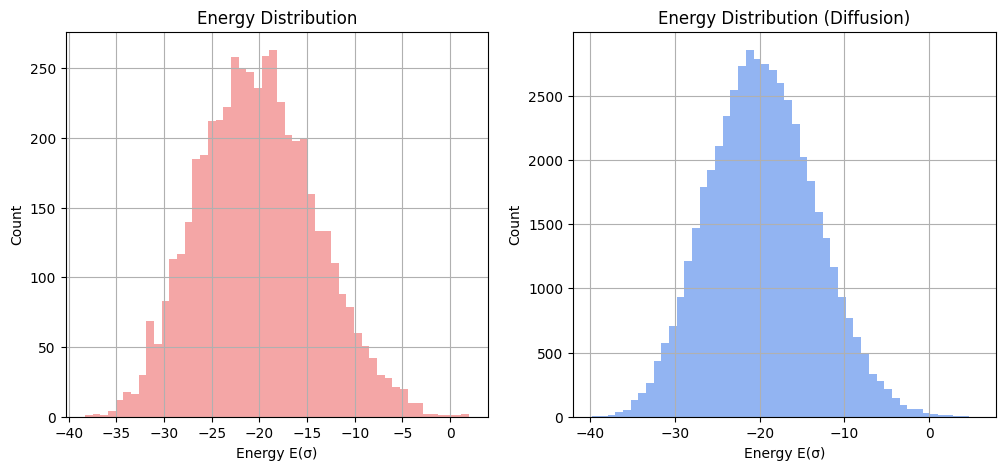

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
L, N = s.shape
h = b
J = w
energies = np.array([-np.dot(s[i], h) - np.dot(s[i], J @ s[i]) for i in range(L)])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- 1. 에너지 분포 ---
axs[0].hist(energies, bins=50, color='lightcoral', alpha=0.7)
axs[0].set_title("Energy Distribution")
axs[0].set_xlabel("Energy E(σ)")
axs[0].set_ylabel("Count")
axs[0].grid(True)

energies_diff = np.array([-np.dot(x[i], h) - np.dot(x[i], J @ x[i]) for i in range(x.shape[0])])

# --- 2. 에너지 분포 (Diffusion) ---
axs[1].hist(energies_diff, bins=50, color='cornflowerblue', alpha=0.7)  
axs[1].set_title("Energy Distribution (Diffusion)")
axs[1].set_xlabel("Energy E(σ)")
axs[1].set_ylabel("Count")
axs[1].grid(True)

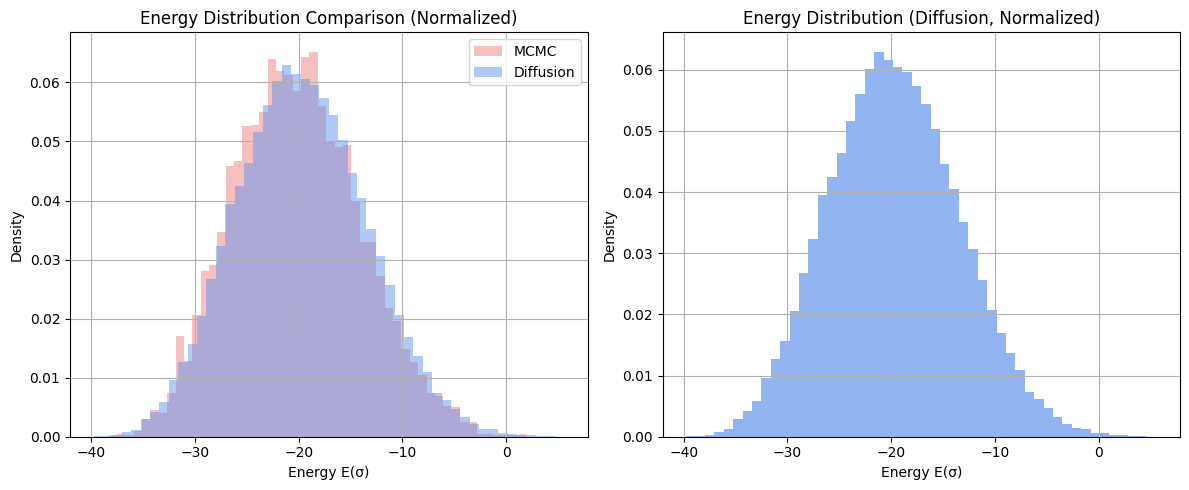

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- 1. 에너지 분포 (겹쳐서 표시, 정규화됨) ---
axs[0].hist(energies, bins=50, color='lightcoral', alpha=0.5, label='MCMC', density=True)
axs[0].hist(energies_diff, bins=50, color='cornflowerblue', alpha=0.5, label='Diffusion', density=True)
axs[0].set_title("Energy Distribution Comparison (Normalized)")
axs[0].set_xlabel("Energy E(σ)")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].grid(True)

# --- 2. 에너지 분포 (Diffusion만, 정규화됨) ---
axs[1].hist(energies_diff, bins=50, color='cornflowerblue', alpha=0.7, density=True)
axs[1].set_title("Energy Distribution (Diffusion, Normalized)")
axs[1].set_xlabel("Energy E(σ)")
axs[1].set_ylabel("Density")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
N = 40
b_s, w_s = train_erasure_machine(s, N, epsilon=0.84, lr=0.1, epochs=150)
b_s_1, w_s_1 = train_erasure_machine(s, N, epsilon=0.7, lr=0.1, epochs=150)
mse_new = mse(w, w_s,b,b_s)
mse_new_1 = mse(w, w_s_1,b,b_s_1)
print(f"New MSE: {mse_new:.4f}")
print(f"New MSE: {mse_new_1:.4f}")

Epoch 0: b norm = 0.2009, w norm = 0.7146
Epoch 10: b norm = 0.9824, w norm = 3.3044
Epoch 20: b norm = 1.1946, w norm = 4.0494
Epoch 30: b norm = 1.2679, w norm = 4.3038
Epoch 40: b norm = 1.2951, w norm = 4.3951
Epoch 50: b norm = 1.3055, w norm = 4.4287
Epoch 60: b norm = 1.3096, w norm = 4.4413
Epoch 70: b norm = 1.3112, w norm = 4.4460
Epoch 80: b norm = 1.3118, w norm = 4.4478
Epoch 90: b norm = 1.3120, w norm = 4.4485
Epoch 100: b norm = 1.3121, w norm = 4.4488
Epoch 110: b norm = 1.3122, w norm = 4.4489
Epoch 120: b norm = 1.3122, w norm = 4.4489
Epoch 130: b norm = 1.3122, w norm = 4.4490
Epoch 140: b norm = 1.3122, w norm = 4.4490
Epoch 0: b norm = 0.2073, w norm = 0.7053
Epoch 10: b norm = 0.8920, w norm = 3.0537
Epoch 20: b norm = 1.1086, w norm = 3.8454
Epoch 30: b norm = 1.1979, w norm = 4.1661
Epoch 40: b norm = 1.2369, w norm = 4.3020
Epoch 50: b norm = 1.2541, w norm = 4.3608
Epoch 60: b norm = 1.2618, w norm = 4.3865
Epoch 70: b norm = 1.2653, w norm = 4.3979
Epoch 80

In [11]:
mse_new_1

1.4462306853286355e-07

In [12]:
b_list = []
w_list = []

b_list_1 = []
w_list_1 = []

mse_list = []
mse_list_1 = []
for epoch in range(1,50):
    real_epoch = epoch * 1000
    x_= load_multi_samples(name = real_epoch, batch_size=5000, total_samples=50000)
    b_in, w_in = train_erasure_machine_torch(x_, N, epsilon=0.84, lr=0.1, epochs=150)
    b_in_1, w_in_1 = train_erasure_machine_torch(x_, N, epsilon=0.7, lr=0.1, epochs=150)

    b_list.append(b_in)
    w_list.append(w_in)
    b_list_1.append(b_in_1)
    w_list_1.append(w_in_1)

    mse_in = mse(w, w_in, b, b_in)
    mse_in_1 = mse(w, w_in_1, b, b_in_1)
    mse_list.append(mse_in)
    mse_list_1.append(mse_in_1)

# np.save(f"b_list_50K.npy", np.array(b_list))
# np.save(f"w_list_50K.npy", np.array(w_list))
# np.save(f"b_list_1_50K.npy", np.array(b_list_1))
# np.save(f"w_list_1_50K.npy", np.array(w_list_1))
# np.save(f"mse_list_50K.npy", np.array(mse_list))
# np.save(f"mse_list_1_50K.npy", np.array(mse_list_1))

[GPU] Epoch 0: b norm = 0.2979, w norm = 0.9237
[GPU] Epoch 10: b norm = 1.2824, w norm = 3.3539
[GPU] Epoch 20: b norm = 1.5325, w norm = 3.8727
[GPU] Epoch 30: b norm = 1.6191, w norm = 4.0318
[GPU] Epoch 40: b norm = 1.6517, w norm = 4.0841
[GPU] Epoch 50: b norm = 1.6643, w norm = 4.1017
[GPU] Epoch 60: b norm = 1.6693, w norm = 4.1078
[GPU] Epoch 70: b norm = 1.6713, w norm = 4.1099
[GPU] Epoch 80: b norm = 1.6721, w norm = 4.1107
[GPU] Epoch 90: b norm = 1.6724, w norm = 4.1110
[GPU] Epoch 100: b norm = 1.6725, w norm = 4.1111
[GPU] Epoch 110: b norm = 1.6725, w norm = 4.1111
[GPU] Epoch 120: b norm = 1.6726, w norm = 4.1111
[GPU] Epoch 130: b norm = 1.6726, w norm = 4.1111
[GPU] Epoch 140: b norm = 1.6726, w norm = 4.1111
[GPU] Epoch 0: b norm = 0.2950, w norm = 0.9348
[GPU] Epoch 10: b norm = 1.1245, w norm = 2.8412
[GPU] Epoch 20: b norm = 1.3725, w norm = 3.3424
[GPU] Epoch 30: b norm = 1.4723, w norm = 3.5151
[GPU] Epoch 40: b norm = 1.5154, w norm = 3.5781
[GPU] Epoch 50: b

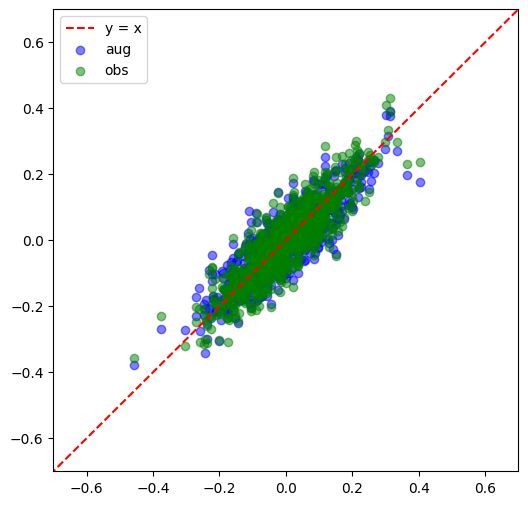

In [13]:
x = np.concatenate([b, w[np.triu_indices_from(w, k=1)]])
y_s = np.concatenate([b_s, w_s[np.triu_indices_from(w, k=1)]])
y = np.concatenate([b_list[10], w_list[10][np.triu_indices_from(w, k=1)]])

plt.figure(figsize=(6, 6))
plt.plot([-1, 1], [-1, 1], 'r--', label='y = x')
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.scatter(x, y, label='aug', alpha=0.5, color='blue')
plt.scatter(x, y_s, label='obs', alpha=0.5, color='green')
plt.legend()
plt.show()

(40, 40)


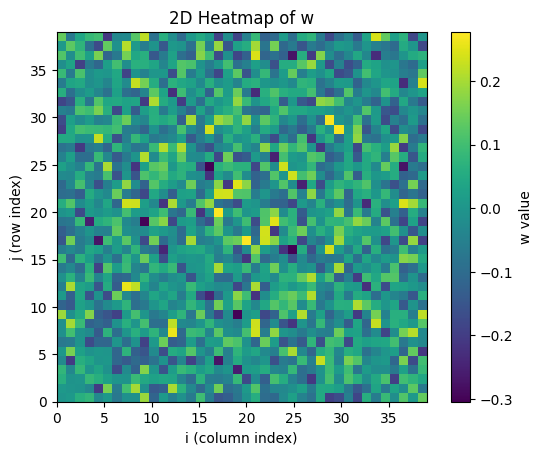

In [14]:
tensor = np.tile(np.arange(40), (40, 1))
print(tensor.shape)
plt.imshow(w_list[10], origin='lower', cmap='viridis', extent=[0, 39, 0, 39])
plt.colorbar(label='w value')
plt.xlabel('i (column index)')
plt.ylabel('j (row index)')
plt.title('2D Heatmap of w')
plt.show()

In [15]:
b_list = []
w_list = []

b_list_1 = []
w_list_1 = []

mse_list = []
mse_list_1 = []
for epoch in range(1,50):
    real_epoch = epoch * 1000
    x_= load_multi_samples(name = real_epoch, batch_size=5000, total_samples=100000)
    b_in, w_in = train_erasure_machine_torch(x_, N, epsilon=0.84, lr=0.1, epochs=150)
    b_in_1, w_in_1 = train_erasure_machine_torch(x_, N, epsilon=0.7, lr=0.1, epochs=150)

    b_list.append(b_in)
    w_list.append(w_in)
    b_list_1.append(b_in_1)
    w_list_1.append(w_in_1)

    mse_in = mse(w, w_in, b, b_in)
    mse_in_1 = mse(w, w_in_1, b, b_in_1)
    mse_list.append(mse_in)
    mse_list_1.append(mse_in_1)

# np.save(f"b_list_100K.npy", np.array(b_list))
# np.save(f"w_list_100K.npy", np.array(w_list))
# np.save(f"b_list_1_100K.npy", np.array(b_list_1))
# np.save(f"w_list_1_100K.npy", np.array(w_list_1))
# np.save(f"mse_list_100K.npy", np.array(mse_list))
# np.save(f"mse_list_1_100K.npy", np.array(mse_list_1))

[GPU] Epoch 0: b norm = 0.2925, w norm = 0.9299
[GPU] Epoch 10: b norm = 1.2822, w norm = 3.3539
[GPU] Epoch 20: b norm = 1.5333, w norm = 3.8693
[GPU] Epoch 30: b norm = 1.6201, w norm = 4.0263
[GPU] Epoch 40: b norm = 1.6526, w norm = 4.0776
[GPU] Epoch 50: b norm = 1.6651, w norm = 4.0949
[GPU] Epoch 60: b norm = 1.6701, w norm = 4.1008
[GPU] Epoch 70: b norm = 1.6720, w norm = 4.1028
[GPU] Epoch 80: b norm = 1.6728, w norm = 4.1035
[GPU] Epoch 90: b norm = 1.6731, w norm = 4.1038
[GPU] Epoch 100: b norm = 1.6733, w norm = 4.1039
[GPU] Epoch 110: b norm = 1.6733, w norm = 4.1039
[GPU] Epoch 120: b norm = 1.6733, w norm = 4.1039
[GPU] Epoch 130: b norm = 1.6733, w norm = 4.1039
[GPU] Epoch 140: b norm = 1.6733, w norm = 4.1039
[GPU] Epoch 0: b norm = 0.2856, w norm = 0.9345
[GPU] Epoch 10: b norm = 1.1190, w norm = 2.8336
[GPU] Epoch 20: b norm = 1.3676, w norm = 3.3261
[GPU] Epoch 30: b norm = 1.4668, w norm = 3.4923
[GPU] Epoch 40: b norm = 1.5094, w norm = 3.5516
[GPU] Epoch 50: b

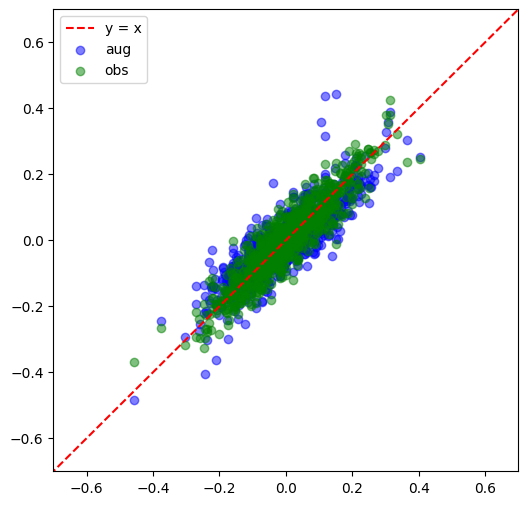

In [16]:
x = np.concatenate([b, w[np.triu_indices_from(w, k=1)]])
y_s = np.concatenate([b_s_1, w_s_1[np.triu_indices_from(w, k=1)]])
y = np.concatenate([b_list_1[0], w_list_1[0][np.triu_indices_from(w, k=1)]])

plt.figure(figsize=(6, 6))
plt.plot([-1, 1], [-1, 1], 'r--', label='y = x')
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.scatter(x, y, label='aug', alpha=0.5, color='blue')
plt.scatter(x, y_s, label='obs', alpha=0.5, color='green')
plt.legend()
plt.show()

(40, 40)


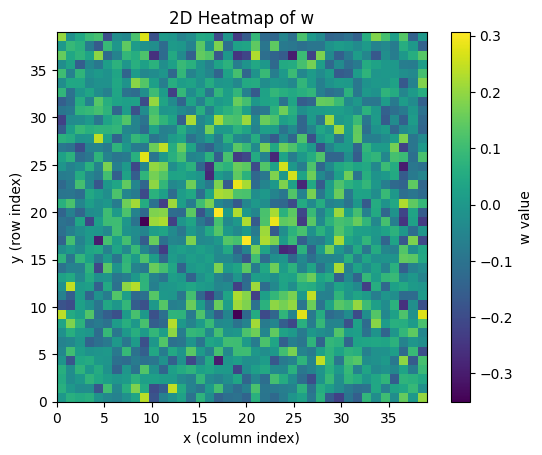

In [17]:
tensor = np.tile(np.arange(40), (40, 1))
print(tensor.shape)
plt.imshow(w_list[0], origin='lower', cmap='viridis', extent=[0, 39, 0, 39])
plt.colorbar(label='w value')
plt.xlabel('x (column index)')
plt.ylabel('y (row index)')
plt.title('2D Heatmap of w')
plt.show()